# <center> CFRM521 Machine Learning in Finance
## <center> Lecture 11
### <center> Yoshihiro Shirai

# Dimensionality Reduction

- These lecture notes are partially based on "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition, by Aurelien Geron (O'Reilly), 2022."

- Chapter 8: PCA, kernel PCA, Locally linear Embedding (LLE)

#  0. Overview of the lecture

- We discuss dimensionality reduction, starting with the **curse of dimensionality**, which explains why high dimensional data sets with a large number of features are increasingly hard to handle.

- Next, we introduce **Principle Component Analysis (PCA)**, looking at how many principal components to choose, and the reconstruction error.

- We next consider extending PCA for non-linear dimension reduction using the **kernel trick**.

- Finally, we explain a different dimension reduction technique called **locally linear embedding (LLE)** which is related to k-NN and based on manifold learning in contrast to PCA, which was based on projection.

<h1 id="2.-Curse-of-dimensionality">2. Curse of dimensionality<a class="anchor-link" href="#2.-Curse-of-dimensionality"></a></h1><ul>

- Needless to say, increasing the number of features makes training and interpreting the results more difficult.</li>

- In many scenarios, the training algorithms will become intractable once you increase the number of features. This problem is referred to as the <strong>curse of dimensionality</strong>.

- In many cases, it is possible to reduce the number of features by <strong>eliminating</strong> unimportant features or <strong>aggregating</strong> several features into one new features. By doing so, we transform an intractable high dimensional problem into a tractable lower dimensional problem. This technique is called <strong>dimension reduction</strong>.

- Another use of dimension reduction is in data visualization. Since humans only interpret in 3 dimensions, it is helpful to use dimension reduction to transform high dimensional data down to less than three dimensions.

- Why is dimensionality a "curse"? What happens to datasets as their dimensionality increases?As it turns out, high dimensional data are usually much more sparsely distributed than lower dimensional data.

- Assume that you are creating $K$ features at random. That is, $\mathbf{X}_n = (X_{n,1}, \dots, X_{n,K})$ where $X_{n,k}\overset{i.i.d.}{\sim} U(0,1)$. Consider a sample $\{\mathbf{X}_n\}_{n=1}^N$.

- What percentage of data have at least one extreme feature, that is one feature which is near to zero or 1? That is
$$\begin{align*}
    & \mathbb{P}\left(\cup_{k=1}^K \left[\{X_{n,k}<\varepsilon\}\cup \{X_{n,k}>1-\varepsilon\}\right] \right)\\
    & = 1- \mathbb{P}\left(\cap_{k=1}^K \varepsilon\le X_{n,k}\le 1-\varepsilon\right)\\
    & = 1- \prod_{k=1}^K\mathbb{P}\left(\varepsilon\le X_{n,k}\le 1-\varepsilon\right)\\
    & = 1 - (1-2\varepsilon)^K
\end{align*}$$

In [1]:
p = lambda eps, K: 1-(1-2*eps)**K
eps=0.001
for K in [2, 724, 5000]:
    print("Probability of extreme observations with {} features = {:.5f}"
          .format(K, p(eps, K)))

Probability of extreme observations with 2 features = 0.00400
Probability of extreme observations with 724 features = 0.76530
Probability of extreme observations with 5000 features = 0.99996


- To see the sparsity of (randomly generated) high dimensional features, we can also calculate the average squared distance between two observations.

- Let $\mathbf{X}_n$ and $\mathbf{X}_{n'}$ be two observations. Let $\mathbf{D}=\mathbf{X}_n-\mathbf{X}_{n'}$. We want to find
$$\begin{align*}
    \mathbb{E}(\|\mathbf{D}\|^2) = \mathbb{E}(D_1^2 + \dots + D_K^2)
\end{align*}$$

- Since $X_{n,k}$ and $X_{n',k}$ are independent uniform $(0,1)$ r.v., we have $\mathbb{E}(X_{n,k})= \mathbb{E}(X_{n',k})=0.5$ and $\mathbb{E}(X_{n,k}^2)=\mathbb{E}(X_{n',k})=1/3$. Therefore,
$$ \begin{align*}
    \mathbb{E}(D_k^2)&= \mathbb{E}\left[(X_{n,k}-X_{n',k})^2\right]\\
    &= \mathbb{E}(X_{n,k}^2)+\mathbb{E}(X_{n',k}^2)-2\mathbb{E}(X_{n,k})\mathbb{E}(X_{n',k})\\
    &=\frac{1}{3}+\frac{1}{3}-\frac{2}{4} = \frac{1}{6}
\end{align*}$$

- Thus, we obtain
$$\begin{align*}
    \mathbb{E}(\|\mathbb{D}\|^2) = \mathbb{E}(\sum_{k=1}^K D_k^2)= \frac{K}{6}. 
\end{align*}$$

- For  $𝐾=2$, the average squared distance is $0.33$, while for  $𝐾=5000$ the average squared distance is $833$.

- This sparsity has the following consequences:
    - We need increasingly more and more observations to cover the whole feature space as its dimension increases.
    - New observations may be far from many existing observations in the sample.

- In general, the risk of overfitting increases with the number of features.


<h1 id="3.-PCA">3. PCA<a class="anchor-link" href="#3.-PCA"></a></h1><ul>

- One of the main approaches for dimension reduction is by <strong>Projection</strong>

- In many high-dimensional datasets, observations are not spread out uniformly across all dimensions. Many features may be constants (like the margin pixels in the MNIST dataset), and other features may be highly correlated.

- As a result, the observations almost lie on a lower dimensional subspace.

- To reduce the dimensionality of a dataset, we can project it to this lower dimensional subspace.

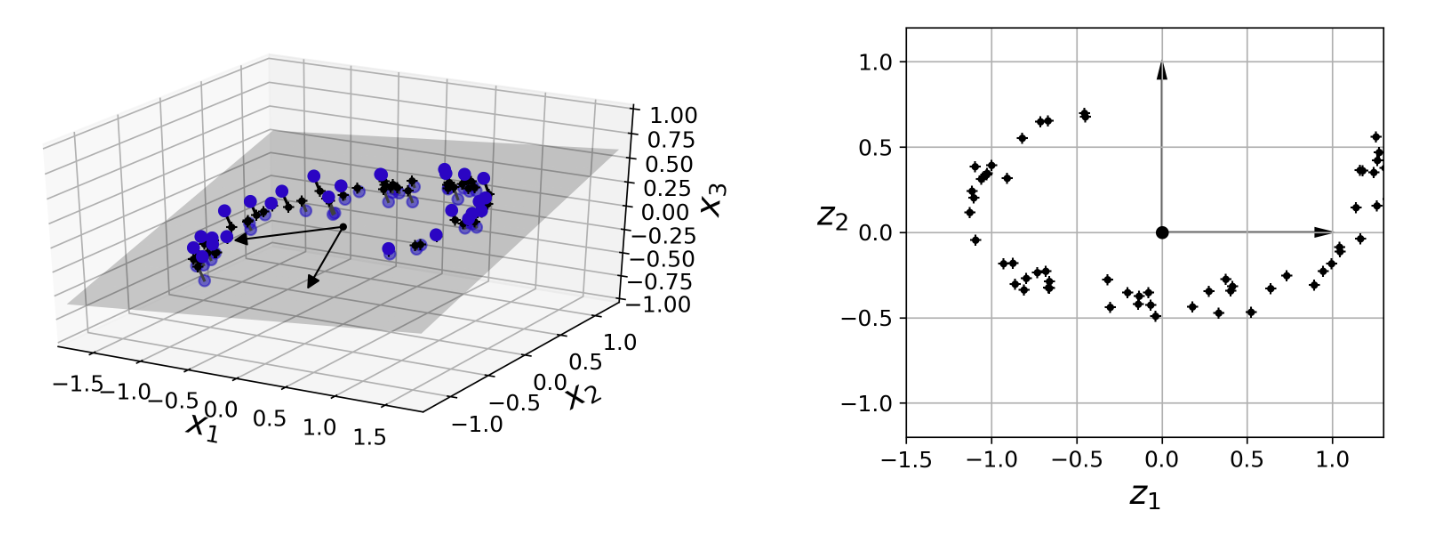

In [2]:
from IPython.display import Image
Image("Figs/projection.png",width=800)

- <strong>Principal Component Analysis (PCA)</strong> is a popular dimension reduction technique based on projection.

- The underlying idea of PCA is very simple:
    - Find the direction, represented by the unit vector $\mathbf{c}_1$, that preserves the most variation in the data. This direction is called the **first principal axis**. The projections of the data in the direction of $\mathbf{c}_1$ are called the **first principal components**
    - Then, find a direction $\mathbf{c}_2$ perpendicular to the previous direction that preserves the most variation in the data set. $\mathbf{c}_2$ is called the <strong>second principal axis</strong>. The projected observation in the direction of $\mathbf{c}_2$ are called the **second principal components**
    - Assuming that you still have dimension left, find a third direction perpendicular to the first two directions the preserves the most variation in the data set. Define the $k$-th principal axis and components as above.
    - Continue this process until there is no dimension left (i.e. until you find the K-th principal components)

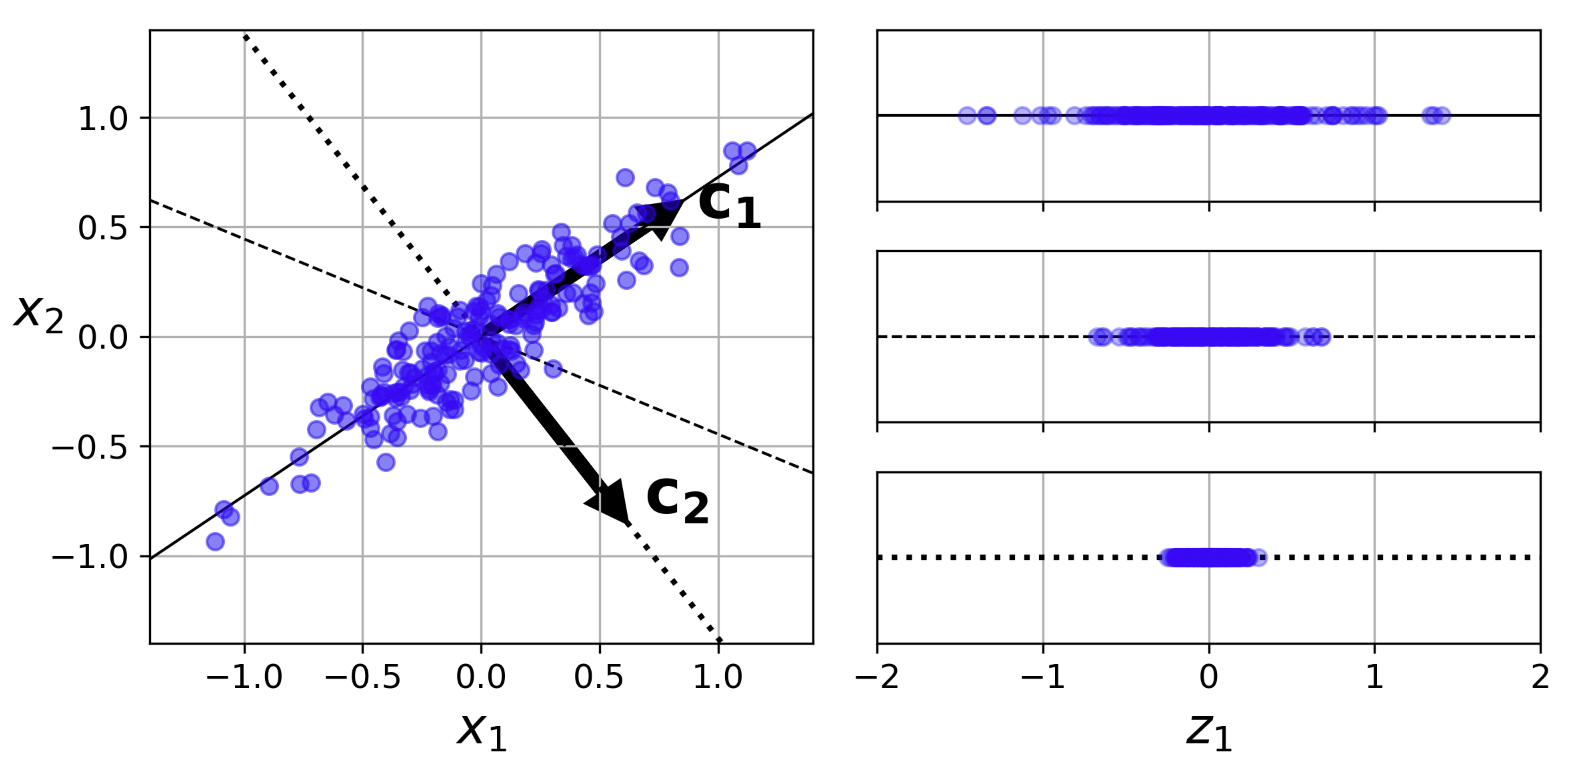

In [3]:
Image("Figs/pca_best_projection.png",width=800)

##  2.1 Projecting down to reduce dimensions

- Let $\{\mathbf{X}_n=(X_{n,1},\dots,X_{n,K})\}$ be the feature vectors. We assume that the featured are centered around zero. It they are not, we have to center them for the following argument to be correct.

- Define the feature matrix
$$\begin{align*}
    \mathbf{X} = \begin{bmatrix}X_{1,1} & \dots & X_{1,K}\\ X_{2,1} & \dots & X_{2,K}\\ \vdots  & \ddots & \vdots\\ X_{N,1} & \dots & X_{N,K}\end{bmatrix}
\end{align*}$$

- By the <strong>singular value decomposion (SVD)</strong>, there are orthogonal matrices $U$ and $V$ and a rectangular diagonal matrix $\Sigma$ such that
$$\begin{align*}
    \mathbf{X} = U \Sigma V^\top
\end{align*}$$

- The columns of $V$ are the principal axis, that is
$$\begin{align*}
    V = [\mathbf{c}_1~\mathbf{c}_2~\dots~\mathbf{c}_K]
\end{align*}$$

- Instead of using singular value decomposition on $\mathbf{X}$, you can use <strong>eigenvalue decomposition</strong> on the sample covariance (or correlation) matrix of the feature vectors. The result would be the same

- To illustrate PCA, let us generate a sample with three features. This is the 3 dimensional example shown above.


In [4]:
import numpy as np
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)


We can use the function `numpy.linalg.svd()` for SVD. Note that for SVD to return the principal axis, we have to center the features first (i.e. subtract their means).

In [5]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
Vt.T

array([[ 0.93636116, -0.34027485, -0.08626012],
       [ 0.29854881,  0.90119108, -0.31420255],
       [ 0.18465208,  0.2684542 ,  0.94542898]])

Instead of doing SVD, we can use the `sklearn.decomposition.PCA` class to perform PCA. `n_components` is the number of principal axis.

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
pca.fit(X)
pca.components_.T

array([[-0.93636116,  0.34027485, -0.08626012],
       [-0.29854881, -0.90119108, -0.31420255],
       [-0.18465208, -0.2684542 ,  0.94542898]])

- Notice that the principal axes from both methods are the same up to a constant multiple.

- Once we have all the principal axis, we can project the dataset to any lower dimensional hyperplane while preserving most of the variance.

- Specifically, if the principal axis are $\mathbf{c}_1, \mathbf{c}_2, \dots, \mathbf{c}_K$, then:
    - The best variance preserving 1-dimensional hyperplane (that is, line) is $\mathbf{c}_1$. The projections on this line  are $\mathbf{X} \mathbf{c}_1$, which are the first principal components.
    - The best variance preserving 2-dimensional hyperplane (that is plane) is the span of $\mathbf{c}_1$ and $\mathbf{c}_2$. The projections on this hyperplane are $(\mathbf{X} \mathbf{c}_1, \mathbf{X} \mathbf{c}_2)=\mathbf{X}[\mathbf{c}_1~\mathbf{c}_2]$, which are the first two principal components
    - etc

- In general, the most variance preserving $k$-dimensional hyperplane is the span of $\mathbf{c}_1,\dots,\mathbf{c}_k$, and the projection on this hyperplane (i.e. the first k principal components) are $\mathbf{X}[\mathbf{c}_1\dots\mathbf{c}_k]$

- The <code>PCA</code> class is actually a Scikit-Learn transformer (like the one-hot encoder, standard scaler,...) that returns the principal components. To get principal components, simply use its <code>.transform()</code> method (after fitting it)

In [7]:

X3D = pca.transform(X)
X3D[:3]

array([[ 1.26203346,  0.42067648,  0.0138445 ],
       [-0.08001485, -0.35272239, -0.15436525],
       [ 1.17545763,  0.36085729, -0.00722714]])

- This is not projection to lower dimensions, however!

- We can project down to 2 dimensions by setting `n_components=2`

In [8]:
X2D = pca.set_params(n_components=2).fit_transform(X)
X2D[:3]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729]])

- Or 1 dimension as follows.

In [9]:
X1D = pca.set_params(n_components=1).fit_transform(X)
X1D[:3]


array([[ 1.26203346],
       [-0.08001485],
       [ 1.17545763]])

## 2.2 Choosing the number of dimensions

- How many principal axes should we use? That is, what is the best lower dimensional hyperplane on which to project the dataset?

- In some scenarios, we already have an answer even without looking into the data. For example, if your main purpose is to reduce dimensionality because you want to visualize the data, then the options are 1, 2, or 3 dimensions (depending on your visualization).

- In other scenarios, we decide on the dimension based on <strong>explained variances</strong> of principal axes. Recall that to obtain each principal axis, we find the best variance preserving directions. Roughly speaking, the explained variance of a principal axis, is its corresponding value of the maximum variance. This concept has been explained in CFRM 502.

- You can get explained variances using <code>pca.explained_variance_</code> and <code>.explained_variance_ratio_</code> variable of the PCA class.

In [10]:
pca.set_params(n_components=3).fit(X)
pca.explained_variance_

array([0.77830975, 0.1351726 , 0.01034272])

In [11]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839, 0.01119554])

- Assume that we want to preserve at lease 90% of the variance. Then, we should use 2 dimensions. If we want at lease 70%, we can use 1 dimension. The <code>PCA</code> class automates this procedure. Simply pass a fraction to `n_components`

In [12]:
X90 = pca.set_params(n_components=0.9).fit_transform(X)
X90[:3]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729]])

In [13]:
X90 = pca.set_params(n_components=0.7).fit_transform(X)
X90[:3]


array([[ 1.26203346],
       [-0.08001485],
       [ 1.17545763]])

- Let us take a more interesting example, the MNIST dataset.​

In [82]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)
X_train = mnist["data"][:60000]
X_test  = mnist["data"][60000:]
y_train = mnist["target"][:60000]
y_test  = mnist["target"][60000:]

- We can easily obtain the principal components that keep 95% of the variance. In this case, we can project to 154 dimensions, which is a significant reduction from 724 features!

In [83]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
pca.n_components_

154

- We can also use the plot of cumulative explained variance ratio against the number of principal components.

- Or a <strong>scree plot</strong>, which is the plot of explained variance (ratios) against the number of principal components.

- In either plot, we can choose the <strong>elbow</strong> of the curve.

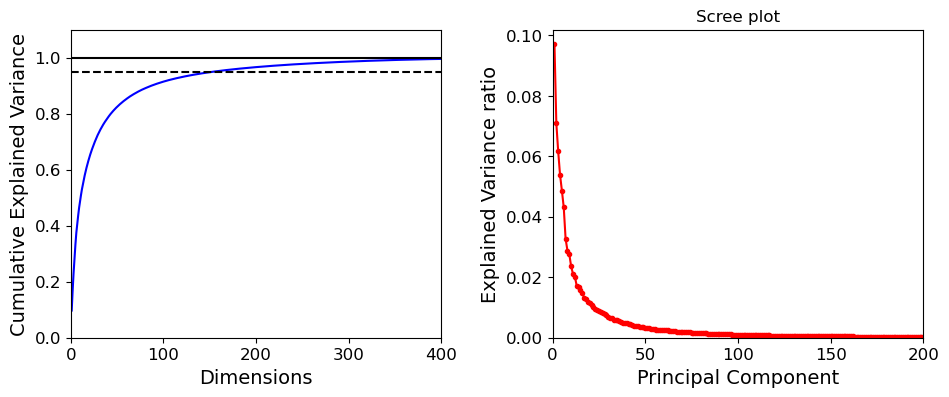

In [84]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

pca.set_params(n_components=784).fit(X_train)

plt.figure(figsize=(11,4))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

plt.subplot(121)
var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(784)+1, var, "b")
plt.plot([0, 784], [1, 1], "k")
plt.plot([0, 784], [0.95, 0.95], "k--")
plt.axis([0, 400, 0, 1.1])
plt.xlabel("Dimensions")
plt.ylabel("Cumulative Explained Variance", fontsize=14)

plt.subplot(122)
eigen = pca.explained_variance_ratio_
plt.plot(np.arange(784)+1, eigen, "r.-")
plt.axis([0, 200, 0, None])
plt.title("Scree plot")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance ratio", fontsize=14)
plt.show()


- Once we decide on the number of principal components, say $d$, we can find the dimensionally reduced dataset by $$\begin{align*}     \text{PC} = \mathbf{X}~ [\mathbf{c}_1\dots\mathbf{c}_d]\end{align*},$$  where $PC$ is a $N\times d$ matrix

- We can project the data from the lower dimension to the higher dimension as follows $$\begin{align*}X' = \text{PC}_{N\times d}~[\mathbf{c}_1\dots\mathbf{c}_d]_{d\times K}^\top \end{align*},$$ where $\mathbf{X}'$ is a $N\times K$ matrix

- The <strong>"reconstructed"</strong> dataset $\mathbf{X}'$ loses some variance (i.e. information) compared to the original data, however. The mean squared distance between $\mathbf{X}'$ and $\mathbf{X}$ is called the <strong>reconstruction error</strong>

- Let us see the effect of PCA in the MNIST dataset.

- You can use the `PCA` class `.inverse_transform` to reconstruct the original data from the principal components (with loss of variance, of course)

- We already found out that to preserve 95% of the variance, we need 154 PCs.

- Let us see how the reconstructed images look like.

In [97]:
def original_recovered(X_train, n_components):
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X_train, y_train)
    X_recovered = pca.inverse_transform(X_reduced)
    plt.figure(figsize=(7, 4))

    for idx, X in enumerate((X_train[::2100].values,X_recovered[::2100])):
        plt.subplot(1, 2, idx + 1)
        plt.title(["Original", "Compressed"][idx])
        for row in range(5):
            for col in range(5):
                plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary", vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
                plt.axis([0, 5, 0, 5])
                plt.axis("off")
                

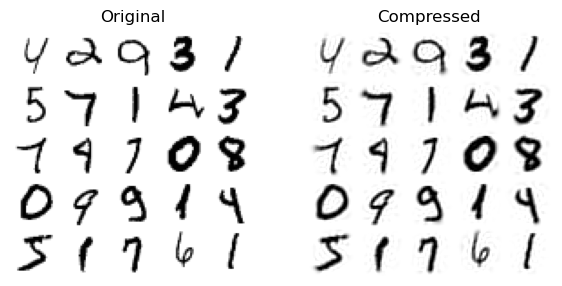

In [98]:
original_recovered(X_train, 154)

- Let us see the quality of the corresponding reconstructed images when using 100 PCs, and also 40, which seems to be the elbow of the scree plot.

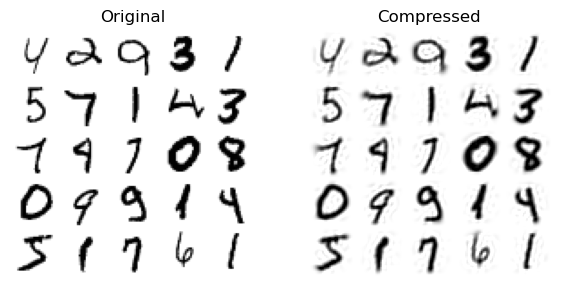

In [103]:
original_recovered(X_train, 100)

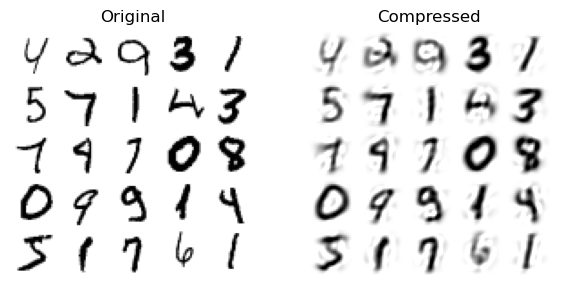

In [104]:
original_recovered(X_train, 40)

- Using 154 PC results in minimal loss of image quality while reducing the dimension to a fifth of the original dimensionality. Using 40 PC may result in a significant loss of quality (though it is still representative of the original data.

- The main advantage is the gain in performance. For example, a kernelized SVM classifier scales linearly with the number of features. Therefore, it will be 5 times faster to use 154 PCs instead of the original 784 features. Using 40 PCs makes the SVM 20 times faster.

- For example, we can use 40 PCs to do grid search, and then train the model using 154 PCs. This will reduce the training times significantly, while preserving the performance of the SVM.

## 3. Nonlinear dimensionality reduction

- PCA is a linear dimension reduction method. It projects onto a lower dimensional hyperplane. There is another approach to dimensionality reduction, called manifold learning.

- Loosely speaking, a manifold in $\mathbb{R}^K$ is a lower dimensional subset that is locally (i.e. once zoomed in around any point on the manifold) a hyperplane.

- The surface of a sphere is an example of a manifold (if we stand on the surface of the earth, it looks flat). The swiss roll is another example of a manifold.


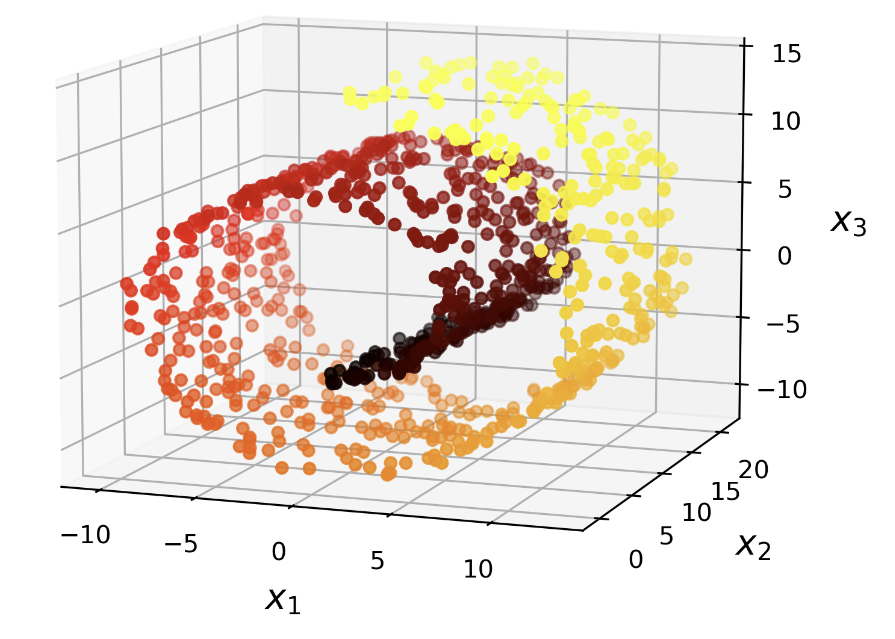

In [106]:
from IPython.display import Image
Image("Figs/swiss_roll_plot.png",width=600)

- The underlying assumption behind manifold learning is that most high-dimensional datasets lie close to a lower-dimensional manifold. This assumption is usually refered to as the manifold hypothesis and is often observed empirically.

- Note that the manifold hypothesis is a generalization of the assumption we made for PCA. In PCA we assumed that the data is near a hyperplane (which is a flat manifold).

- The goal of manifold learning is to find the manifold that is nearest to the observations in a data set.

- The plot on the left squishes the roll by dropping the $x_3$ axis, whereas mannifold learning can be seen as "unrolling" the dataset, which is plotted on the right.

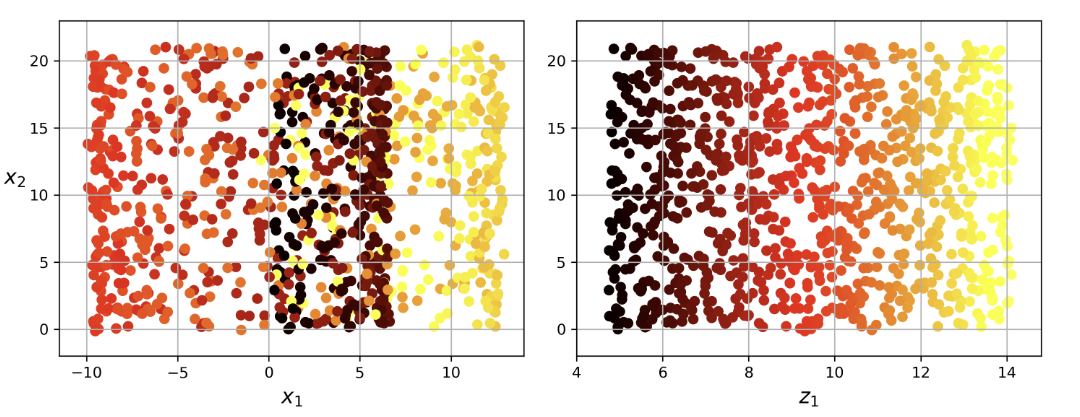

In [107]:
Image("Figs/squished_swiss_roll_plot.png",width=800)

- A word of caution before we proceed: manifold learning (and dimensionality reduction in general) does not necessarily make training a model easier (or faster).

- Consider the following classification task on the swiss roll dataset. Reducing to 2-dimension will actually make the boundaries more complicated!

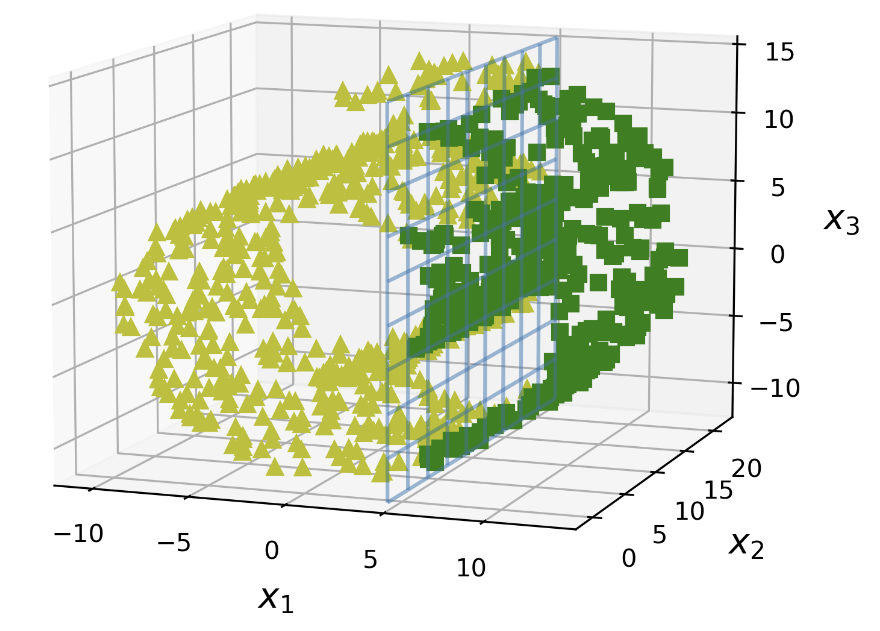

In [108]:
Image("Figs/manifold_decision_boundary_plot1.png",width=600)

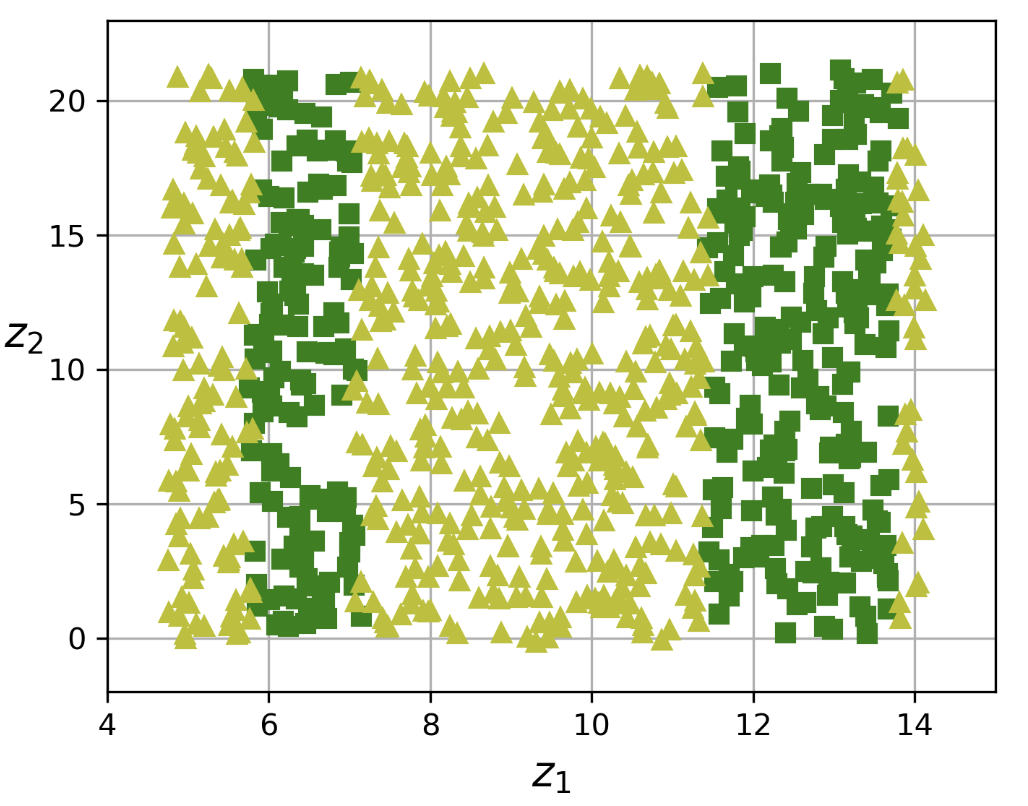

In [109]:
Image("Figs/manifold_decision_boundary_plot2.png",width=600)

- In another scenario, however, manifold learning makes the problem easier.

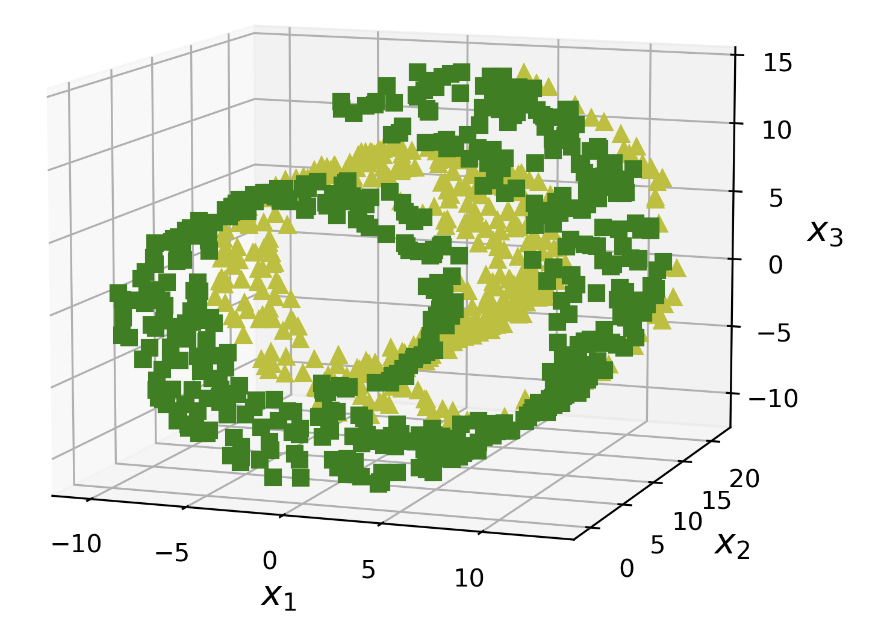

In [110]:
Image("Figs/manifold_decision_boundary_plot3.png",width=600)

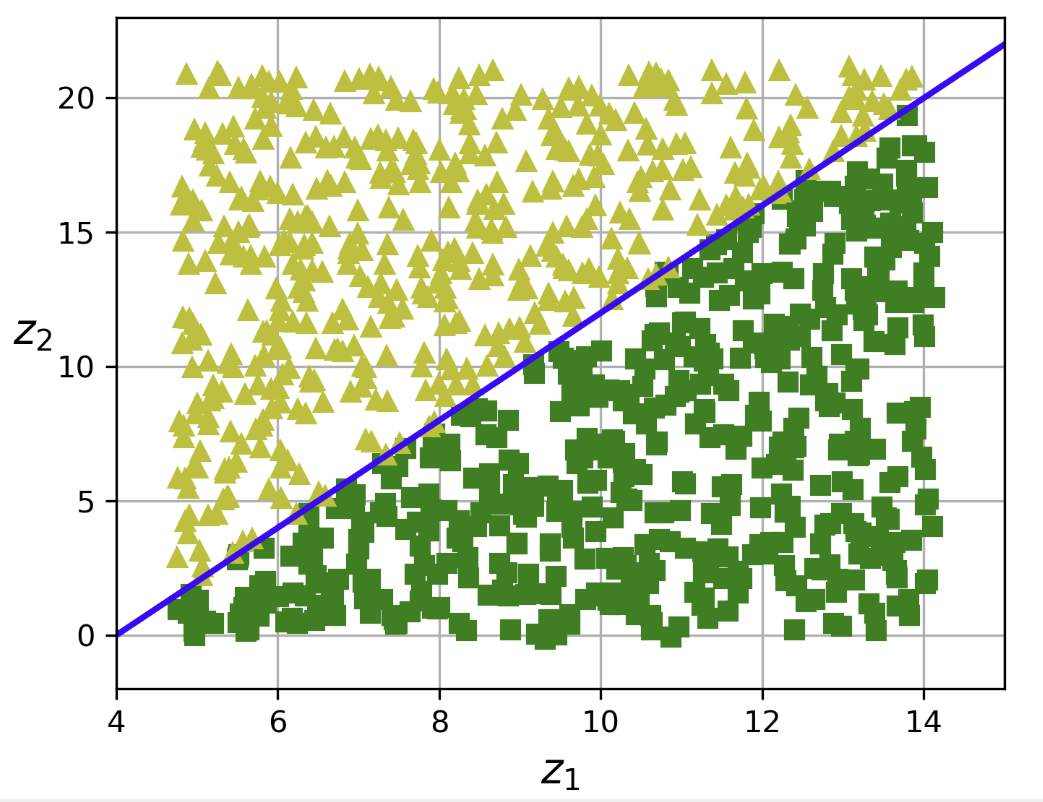

In [111]:
Image("Figs/manifold_decision_boundary_plot4.png",width=600)

- The bottom line is:

- dimensionality reduction techniques may improve the speed of training.

- However, there is no guarantee that the lower dimensional problem has a simpler solution. Depending on the dataset, the solution may be simpler or not.

- We consider 2 forms of nonlinear dimensionality reduction: **kernel PCA** and **LLE**.

## 3.1. Kernel PCA

- Recall that PCA is linear, and like other linear methods, it can be restrictive and results in underfitting.

- To illustrate, recall the "Swiss roll" dataset. We can create this data as follows.

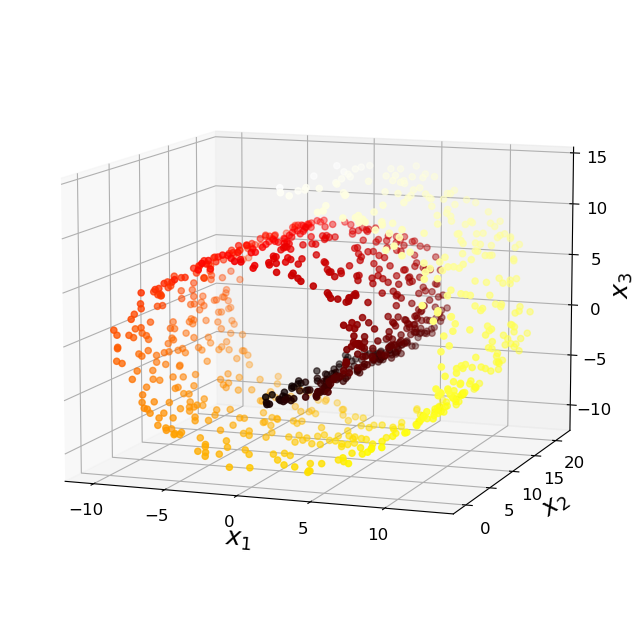

In [112]:
from sklearn.datasets import make_swiss_roll
from mpl_toolkits.mplot3d import Axes3D

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()


- We can easily project to 2 dimensions using PCA.

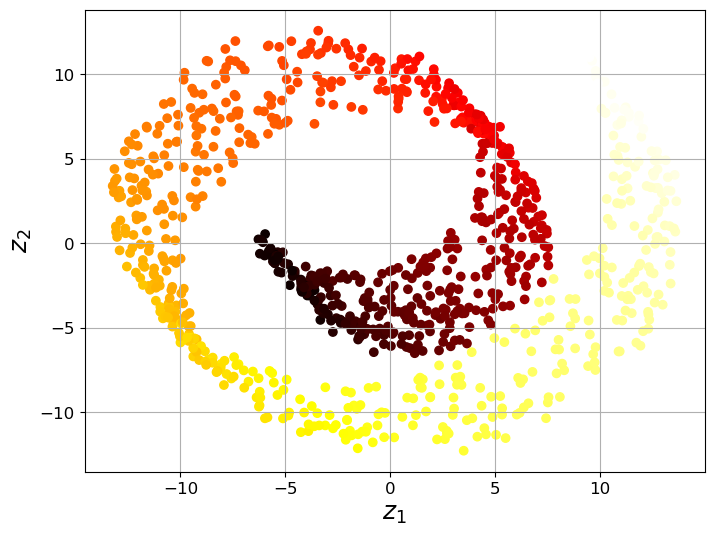

In [113]:
from sklearn.decomposition import PCA
pca = PCA()

X2D = pca.set_params(n_components=2).fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X2D[:, 0], X2D[:, 1], c=t, cmap=plt.cm.hot)

plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.grid(True)
plt.show()

- Let us see what PCA does in this case. First, we project the principal components back to the original space (using the ``.inverse_transform()` method). Then, we plot the original and reconstructed observations.

In [115]:
X_recovered = pca.inverse_transform(X2D)

In [116]:
def show_axis(X, t, subplot, view_angle, title=None):
    ax = fig.add_subplot(subplot, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
    ax.view_init(view_angle[0], view_angle[1])
    ax.set_xlabel("$x_1$", fontsize=18)
    ax.set_ylabel("$x_2$", fontsize=18)
    ax.set_zlabel("$x_3$", fontsize=18)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])
    plt.title(title, fontsize=18)

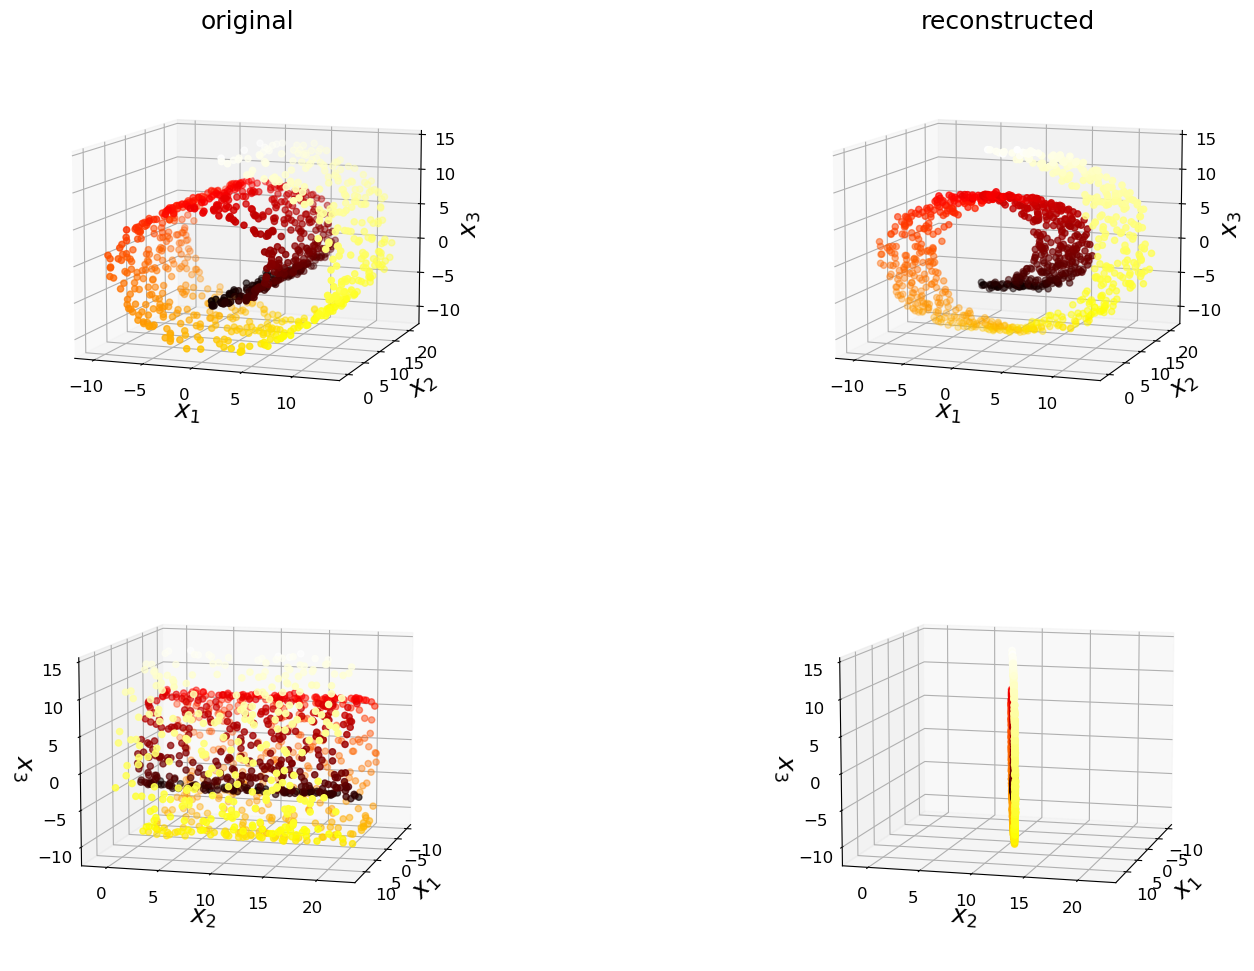

In [117]:
fig = plt.figure(figsize=(18, 12))

show_axis(X, t, 221, (10, -70), "original")
show_axis(X_recovered, t, 222, (10, -70), "reconstructed")
show_axis(X, t, 223, (10, 15))
show_axis(X_recovered, t, 224, (10, 15))
plt.show()

- As you can see, projecting to a plane is not the best strategy.

- If we could somehow project into a "curved surface", we could get a better representation. Recall that such curved surfaces are manifolds.

- But, how can we get such manifolds?

- We can add, say, polynomial features. Then, use PCA on the higher dimensional "feature space".

- The kernel trick that we learned for SVM is applicable to PCA. In essence, we can get the benefit of adding features without actually adding them.

- We can use `sklearn.decomposition.KernelPCA` class to perform kernel PCA. The kernels are similar to the ones available for SVM.

- Compared to PCA, it is harder to go from the principal components back to the original space (that is reconstructing the original observations from principal components). See Footnote 7, Chapter 8 of the textbook for further details. To be able to use the ``.inverse_transform()`` method of the KernelPCA class, you should pass the argument fit_inverse_transform=True.

In [118]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA()
X2D_RBFPCA = kpca.set_params(n_components=2,
                             kernel="rbf", gamma=0.04,
                             fit_inverse_transform=True).fit_transform(X)
X_recovered_RBFPCA = kpca.inverse_transform(X2D_RBFPCA)

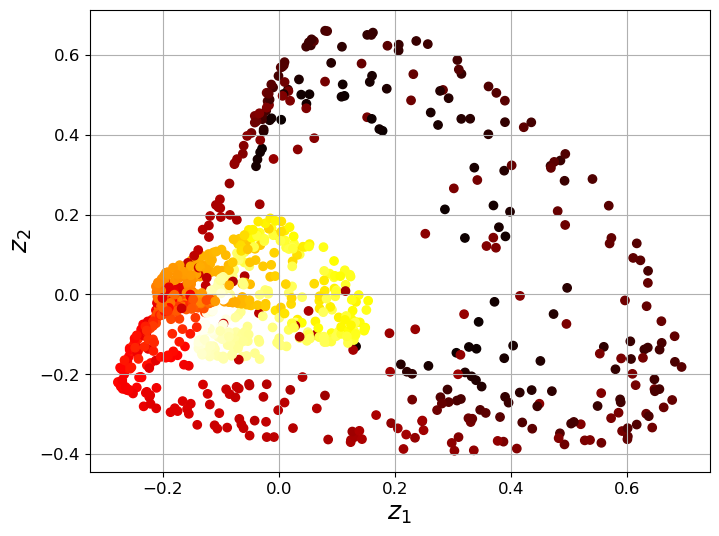

In [119]:
plt.figure(figsize=(8,6))
plt.scatter(X2D_RBFPCA[:, 0], X2D_RBFPCA[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.grid(True)
plt.show()

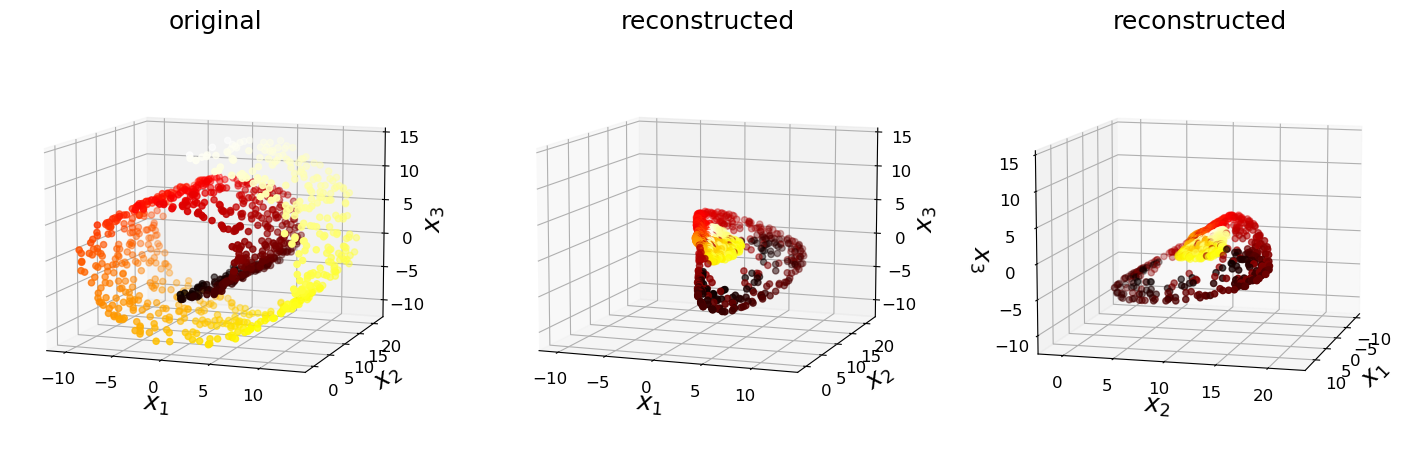

In [120]:
fig = plt.figure(figsize=(18, 6))

show_axis(X, t, 131, (10, -70), "original")
show_axis(X_recovered_RBFPCA, t, 132, (10, -70), "reconstructed")
show_axis(X_recovered_RBFPCA, t, 133, (10, 15), "reconstructed")

plt.show()

- How can we choose a good kernel and/or values of kernel hyperparameters?

- One approach is to search for the kernel and/or hyperparameters that work best for the eventual task that we have in mind.

- For example, if we are performing PCA to reduce the dimension for a classification task, we can treat the kernel and its hyperparameters as any other hyperparameter and perform a grid search with cross validation.

In [121]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y = t > 6.9

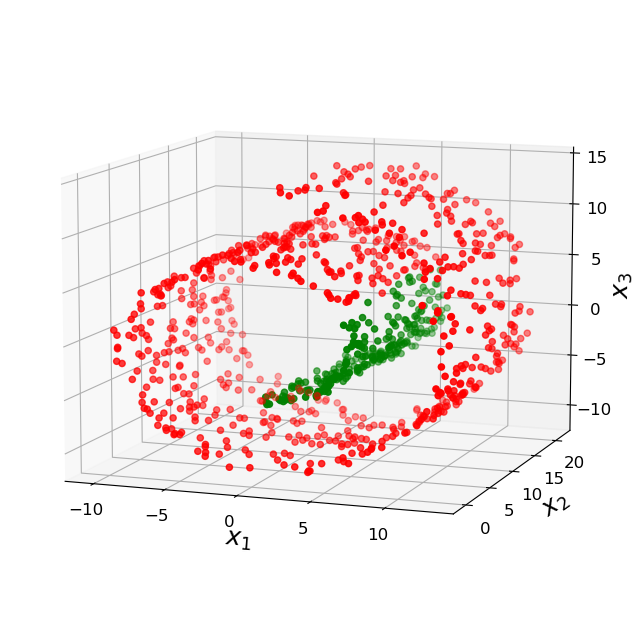

In [122]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[y, 0], X[y, 1], X[y, 2], c='r')
ax.scatter(X[np.logical_not(y), 0], X[np.logical_not(y), 1],
           X[np.logical_not(y), 2], c='g')
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

In [123]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="liblinear"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


- A second approach to find a good kernel, is to minimize the **reconstruction error**. That is, find a kernel for which the reconstructed observations are nearest to the original observations.

In [124]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [125]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.786308795766125

## Locally linear embedding (LLE)

- <strong>Locally linear embedding (LLE)</strong> is a popular manifold learning nonlinear dimensionality reduction technique. It works in two steps:

    - Suppose that you have a set of $M$-dimensional features $S=\{\mathbf{x}_n=(x_{n,1},\dots,x_{n,M})\}_{n=1}^N$.

    - Let $\mathcal{N}_n$ be the index of the $k$ nearest observation to $\mathbf{x}_n$ in $S$. Here, $k\in\{1,2\dots\}$ is a hyperparameter.

    - <strong>Step 1:</strong> Find the <strong>"local relationships"</strong> between the points in $S$, as follows.
        - Estimate each point in $S$ as a linear combination of its $k$ nearest neighbors. That is,
            $$\begin{align*}
                \mathbf{x}_n \approx \sum_{i\in\mathcal{N}_n} w_{n,i} \mathbf{x}_i.
            \end{align*}$$
        - Here, $w_{n,i}$ are normalized such that $\sum_{i\in\mathcal{N}_n}w_{n,i}=1$
        - So, in the first step, we find the weights that minimize the approximation error, by solving the following optimization problem
            $$\begin{align*}
                &\min_{\mathbf{w}}  \sum_{n=1}^N \left\|\mathbf{x}_n - \sum_{i=1}^N w_{n,i} \mathbf{x}_i\right\|^2\\
                &\text{subject to:}\\
                &\quad\quad w_{n,i}=0 \text{ for } i\notin \mathcal{N}_n,\\
                &\quad\quad \sum_{i=1}^N w_{n,i}=1.
            \end{align*}$$
        - let $w^*_{n,i}$ for $n,i\in\{1,\dots,N\}$ be the optimal solution.
    
    - <strong>Step 2:</strong> Consider reducing the dimensionality to $d$, where $d<M$, while preserving the local relationships found in step 1. This is done as follows.
        - Let $\{\mathbf{z}_n=(z_{n,1},\dots,z_{n,d})\}_{n=1}^N$ be the new (lower dimensional) features.
        - Our goal is to minimize $\sum_{n=1}^N\left\|\mathbf{z}_n -\sum_{i\in\mathcal{N}_n} w^*_{n,i} \mathbf{z}_i\right\|^2$, where $w^*_{n,i}$ are the weights we found in Step 1.
        - We have to add some constraint on $\mathbf{z}_n$, otherwise the trivial answer is $z_{n,j}=0$
        - Common constraints are
            $$\begin{align*}
                \sum_{n=1}^N\mathbf{z}_n = \mathbf{0}_{1\times d} &\quad\quad\Longleftrightarrow\quad\quad \sum_{n=1}^N z_{n,j} = 0;\quad\quad j\in\{1,\dots,d\}\\
                \frac{1}{N}\sum_{n=1}^N\mathbf{z}_n^\top \mathbf{z}_n = \mathbf{I}_{d\times d} 
                    &\quad\quad\Longleftrightarrow\quad\quad \frac{1}{N}\sum_{n=1}^N z_{n,j}z_{n,j'} 
                    = \mathbf{I}_{\{j=j'\}};\quad\quad j,j'\in\{1,\dots,d\}.
            \end{align*}$$
        - So, in the second step, we solve the following optimization problem to obtain the lower dimensional features $\{\mathbf{z}^*_n=(z^*_{n,1},\dots,z^*_{n,d})\}_{n=1}^N$:
            $$\begin{align*}
                &\min_{\mathbf{w}}  \sum_{n=1}^N\left\|\mathbf{z}_n -\sum_{i=1}^N w^*_{n,i} \mathbf{z}_i\right\|^2\\
                &\text{subject to:}\\
                &\quad\quad \sum_{n=1}^N z_{n,j} = 0;\quad\quad j\in\{1,\dots,d\},\\
                &\quad\quad \frac{1}{N}\sum_{n=1}^N z_{n,j}z_{n,j'} = \mathbf{1}_{\{j=j'\}};\quad\quad j,j'\in\{1,\dots,d\}.
            \end{align*}$$


- Let us illustrate LLE using the Swiss roll dataset.

In [126]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y = t > 6.9
noty = np.logical_not(y)


- We can use `sklearn.manifold.LocallyLinearEmbedding` class for LLE. The main hyperparameters are n_components which is the reduced dimension $d$, and `n_neighbors` which is the number of neighbors $k$.

- The following code reduces the dimension of the Swiss roll dataset to 2 dimension.

In [130]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

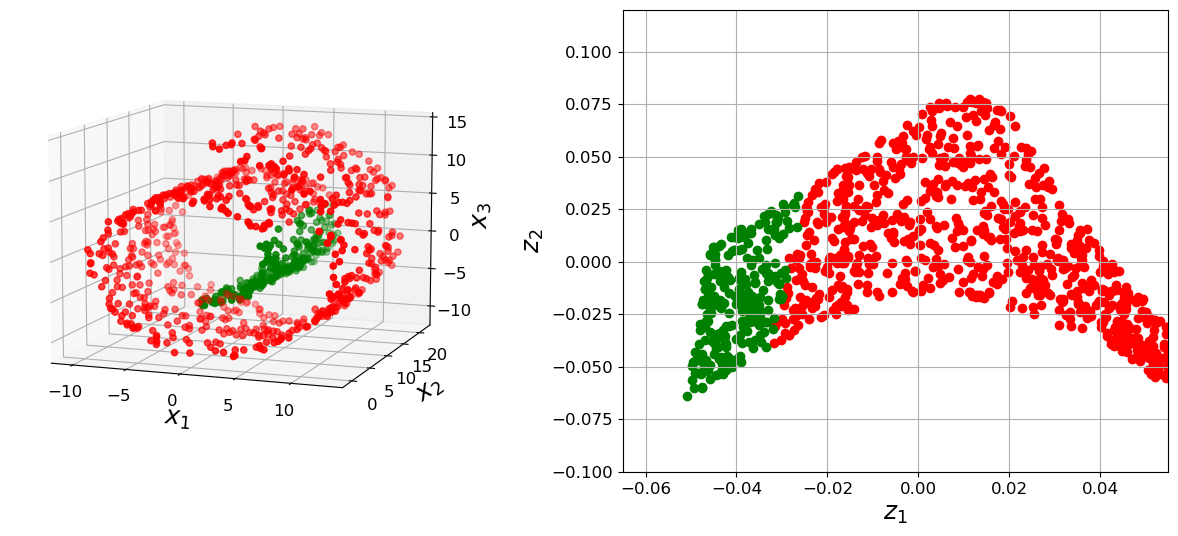

In [131]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')

ax.scatter(X[y, 0], X[y, 1], X[y, 2], c='r')
ax.scatter(X[noty, 0], X[noty, 1],
           X[noty, 2], c='g')
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

fig.add_subplot(122)
plt.subplots_adjust(left = -0.1)
plt.scatter(X_reduced[y, 0], X_reduced[y, 1], c='r')
plt.scatter(X_reduced[noty, 0], X_reduced[noty, 1], c='g')
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()